In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import sklearn 
import cv2
import albumentations as A
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

pd.set_option('display.max_colwidth', 200)

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def show_history(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

In [3]:
def show_history_batch(histories):
    figure, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))  
    # batch 크기별 validation accuracy 비교 
    axs[0].plot(histories[0].history['val_accuracy'], label='batch 32 acc')
    axs[0].plot(histories[1].history['val_accuracy'], label='batch 64 acc')
    axs[0].plot(histories[2].history['val_accuracy'], label='batch 256 acc')
    axs[0].plot(histories[3].history['val_accuracy'], label='batch 512 acc')
    
    # batch 크기별 validation loss 비교
    axs[1].plot(histories[0].history['val_loss'], label='batch 32 loss')
    axs[1].plot(histories[1].history['val_loss'], label='batch 64 loss')
    axs[1].plot(histories[2].history['val_loss'], label='batch 256 loss')
    axs[1].plot(histories[3].history['val_loss'], label='batch 512 loss')
    
    axs[0].legend()
    axs[1].legend()

In [3]:
def show_images(images, labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i], cmap='gray') # .astype("uint8")
        axs[i].set_title(class_names[labels[i]])

In [4]:
from tensorflow.keras.datasets import fashion_mnist

(train_image, train_label), (test_image, test_label) = fashion_mnist.load_data()
train_image.shape, train_label.shape, test_image.shape, test_label.shape

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

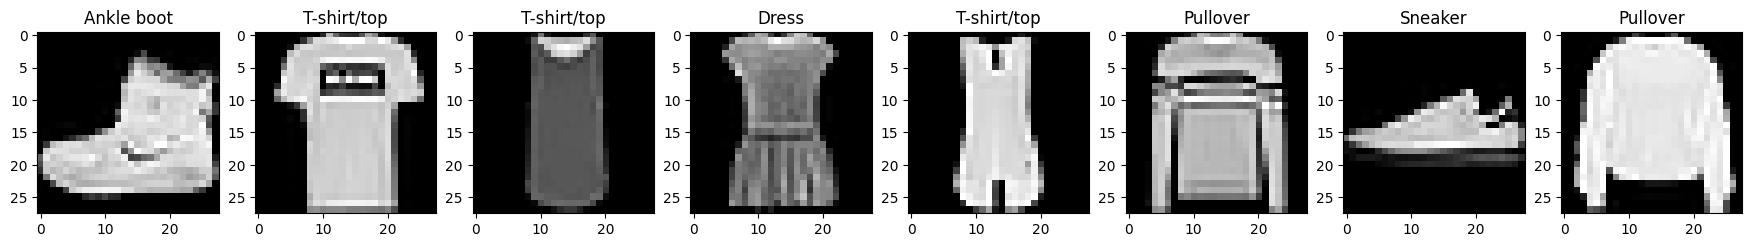

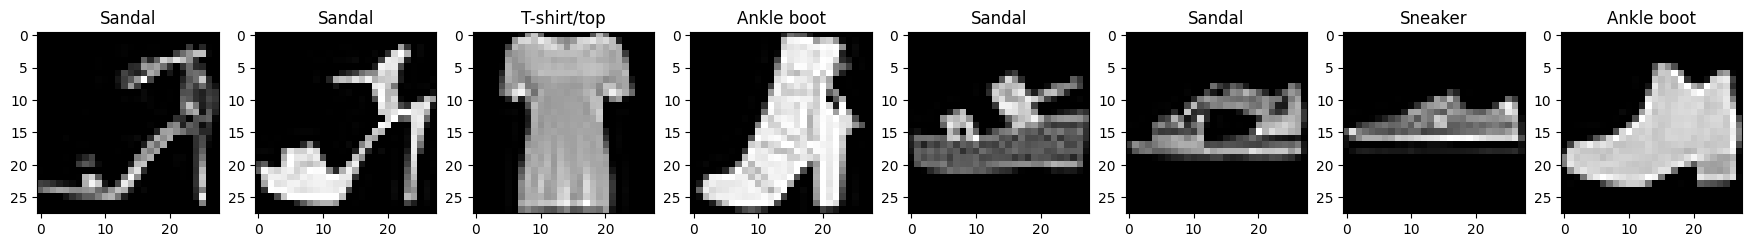

In [39]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        
show_images(train_image[:8], train_label[:8], ncols=8)
show_images(train_image[8:16], train_label[8:16], ncols=8)

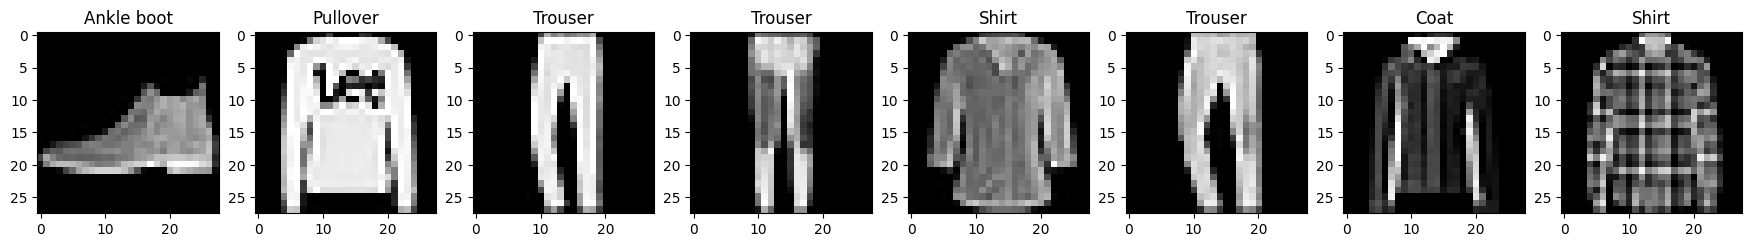

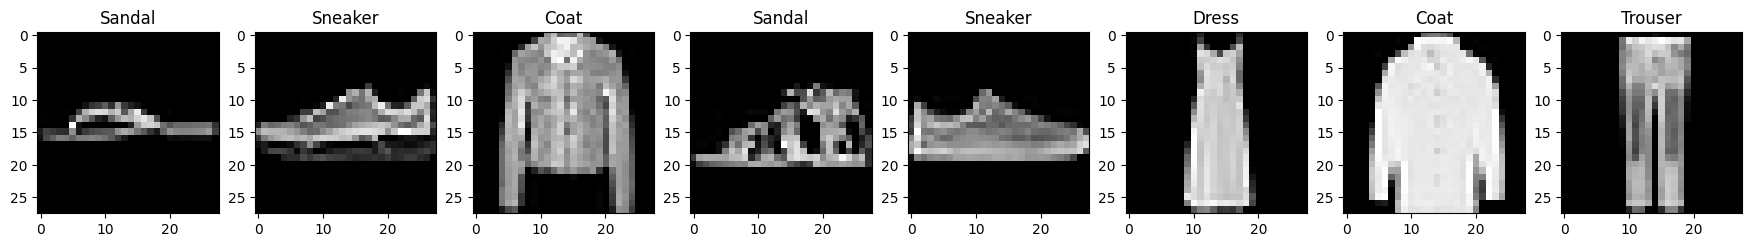

In [40]:
show_images(test_image[:8], test_label[:8], ncols=8)
show_images(test_image[8:16], test_label[8:16], ncols=8)

In [63]:
def get_preprocessed_data(images, labels):
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    return images, labels


def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    oh_labels = to_categorical(labels) # labels OHE 적용 
    return images, oh_labels


def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 


(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_image, train_label, test_image, test_label, valid_size=0.15, random_state=2021)

In [96]:
def create_model_make1():
    input_tensor = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
    x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(2)(x)
    x = Flatten()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(100, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
    return model

model1 = create_model_make1()

Model: "functional_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_132 (Conv2D)             │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_133 (Conv2D)             │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 100)            │     1,081,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,101,526 (4.20 MB)

 Trainable params: 1,101,526 (4.20 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 3번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)

# 5번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [107]:
model1.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True, \
          validation_data=(val_images, val_oh_labels), callbacks=[rlr_cb, ely_cb])

Epoch 1/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9834 - loss: 0.0442 - val_accuracy: 0.9303 - val_loss: 0.3140 - learning_rate: 0.0010
Epoch 2/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9836 - loss: 0.0439 - val_accuracy: 0.9291 - val_loss: 0.3311 - learning_rate: 0.0010
Epoch 3/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9846 - loss: 0.0436 - val_accuracy: 0.9347 - val_loss: 0.3264 - learning_rate: 0.0010
Epoch 4/30
1589/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9864 - loss: 0.0393
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9864 - loss: 0.0393 - val_accuracy: 0.9297 - val_loss: 0.3433 - learning_rate: 0.0010
Epoch 5/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9907 - loss: 0.0276 - val_accuracy: 0.9363 - val_loss: 0.3183 - learning_rate: 2.0000e-04
Epoch 5: early stopping


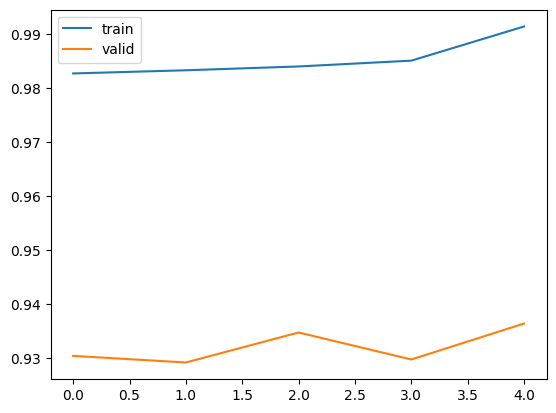

In [108]:
# Train 성능은 매우 높고, 학습이 진행됨에 따라 약간씩 증가하고 있습니다. 거의 0.99에 가까운 성능을 보여 과적합(overfitting)이 의심
# Validation 성능은 Train 성능에 비해 낮고, 거의 개선되지 않는 모습을 보이고 있습니다. 이는 모델이 학습 데이터에는 잘 맞지만, 검증 데이터에는 일반화되지 않고 있음
show_history(history1)

In [109]:
model1.evaluate(test_images, test_oh_labels, batch_size=32)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9345 - loss: 0.3658


[0.3602702021598816, 0.9322999715805054]

In [123]:
preds1 = model1.predict(test_images[:100], batch_size=32)

predicted_class1 = np.argmax(preds1, axis=1)
print('예측 클래스 값:', predicted_class1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
예측 클래스 값: [9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 6 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 6 7 6 7 2 1 6 6 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 4 7 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 2 5 3 6 7 1 8 0 1 2 2]


In [124]:
test_original1 = test_label[0:100]

pred_df1 = pd.DataFrame({'test_original': test_original1, 'predicted_class': predicted_class1})
diff_df = pred_df1[pred_df1['test_original'] != pred_df1['predicted_class']]
diff_df

,test_original,predicted_class
25,4,6
42,3,6
48,2,6
49,2,6
67,3,4
68,9,7
89,6,2
98,4,2


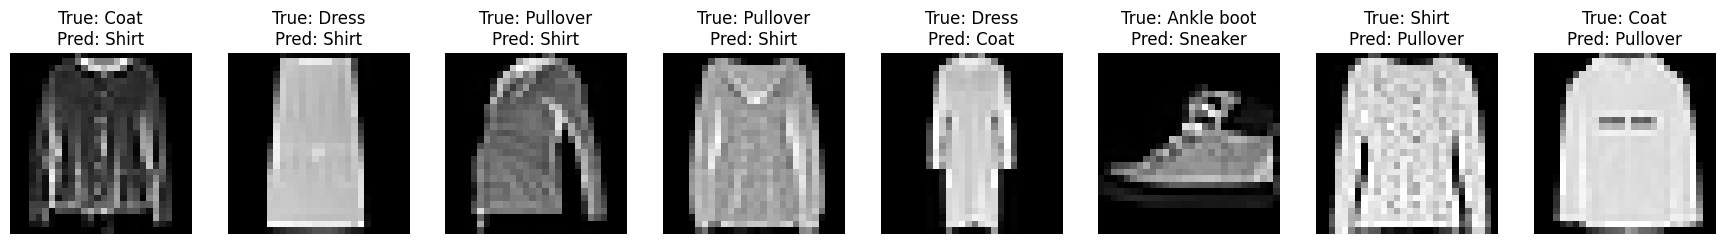

In [11]:
indices = [25, 42, 48, 49, 67, 68, 89, 98]
predicted_class2 = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9, 1, 6, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7,
 5, 7, 9, 6, 1, 6, 7, 6, 7, 2, 1, 6, 6, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 2, 4, 7, 8, 7, 0, 2, 6,
 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 2, 5, 3, 6, 7, 1, 8, 0, 1, 2, 2]
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


def show_images_with_predictions(images, true_labels, pred_labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i].astype("uint8"), cmap='gray') # .astype("uint8")
        axs[i].set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        axs[i].axis('off')
    plt.show()

show_images_with_predictions(
    test_image[indices], 
    test_label[indices], 
    [predicted_class2[i] for i in indices],
    ncols=8
)

In [69]:
b_sizes = [32, 64, 256, 512]
histories = []
evaluations = []

for b_size in b_sizes:
    model1 = create_model_make1()
    model1.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    print('##### batch size :', b_size, '학습 #####')
    history = model1.fit(x=tr_images, y=tr_oh_labels, batch_size=b_size, epochs=30, shuffle=True, 
                        validation_data=(val_images, val_oh_labels))
    histories.append(history)

    evaluation_result = model1.evaluate(test_images, test_oh_labels, batch_size=b_size)
    print('#### 테스트 세트로 evaluation 결과 :', evaluation_result)
    evaluations.append(evaluation_result)

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 100)            │     1,081,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,101,526 (4.20 MB)

 Trainable params: 1,101,526 (4.20 MB)

 Non-trainable params: 0 (0.00 B)

##### batch size : 32 학습 #####
Epoch 1/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8095 - loss: 0.5424 - val_accuracy: 0.8933 - val_loss: 0.2916
Epoch 2/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8963 - loss: 0.2778 - val_accuracy: 0.9100 - val_loss: 0.2509
Epoch 3/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9164 - loss: 0.2204 - val_accuracy: 0.9187 - val_loss: 0.2236
Epoch 4/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9310 - loss: 0.1861 - val_accuracy: 0.9191 - val_loss: 0.2224
Epoch 5/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9405 - loss: 0.1586 - val_accuracy: 0.9249 - val_loss: 0.2075
Epoch 6/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9484 - loss: 0.1397 - val_accuracy: 0.9227 - val_loss: 0.2224
Epoch 7/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9547 - loss: 0.1204 - val_accuracy: 0.9262 - val_loss: 0.2149
Epoch 8/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - ac

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │     1,081,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,101,526 (4.20 MB)

 Trainable params: 1,101,526 (4.20 MB)

 Non-trainable params: 0 (0.00 B)

##### batch size : 64 학습 #####
Epoch 1/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7909 - loss: 0.5817 - val_accuracy: 0.8896 - val_loss: 0.3102
Epoch 2/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8938 - loss: 0.2944 - val_accuracy: 0.8977 - val_loss: 0.2726
Epoch 3/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9112 - loss: 0.2433 - val_accuracy: 0.9132 - val_loss: 0.2343
Epoch 4/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9236 - loss: 0.2070 - val_accuracy: 0.9163 - val_loss: 0.2234
Epoch 5/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9335 - loss: 0.1777 - val_accuracy: 0.9227 - val_loss: 0.2135
Epoch 6/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9422 - loss: 0.1558 - val_accuracy: 0.9199 - val_loss: 0.2191
Epoch 7/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9488 - loss: 0.1359 - val_accuracy: 0.9257 - val_loss: 0.2198
Epoch 8/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9532 - 

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 100)            │     1,081,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,101,526 (4.20 MB)

 Trainable params: 1,101,526 (4.20 MB)

 Non-trainable params: 0 (0.00 B)

##### batch size : 256 학습 #####
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.7333 - loss: 0.7559 - val_accuracy: 0.8736 - val_loss: 0.3593
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8776 - loss: 0.3472 - val_accuracy: 0.8910 - val_loss: 0.3062
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8942 - loss: 0.2943 - val_accuracy: 0.9047 - val_loss: 0.2703
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9072 - loss: 0.2538 - val_accuracy: 0.9098 - val_loss: 0.2494
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9140 - loss: 0.2327 - val_accuracy: 0.9132 - val_loss: 0.2373
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9225 - loss: 0.2118 - val_accuracy: 0.9153 - val_loss: 0.2345
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9270 - loss: 0.1957 - val_accuracy: 0.9196 - val_loss: 0.2206
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 100)            │     1,081,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,101,526 (4.20 MB)

 Trainable params: 1,101,526 (4.20 MB)

 Non-trainable params: 0 (0.00 B)

##### batch size : 512 학습 #####
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.6905 - loss: 0.8988 - val_accuracy: 0.8562 - val_loss: 0.3985
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8708 - loss: 0.3674 - val_accuracy: 0.8869 - val_loss: 0.3247
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8878 - loss: 0.3117 - val_accuracy: 0.8977 - val_loss: 0.2955
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8990 - loss: 0.2809 - val_accuracy: 0.8993 - val_loss: 0.2799
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9077 - loss: 0.2564 - val_accuracy: 0.9078 - val_loss: 0.2564
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9125 - loss: 0.2402 - val_accuracy: 0.8976 - val_loss: 0.2731
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9163 - loss: 0.2326 - val_accuracy: 0.9149 - val_loss: 0.2420
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 

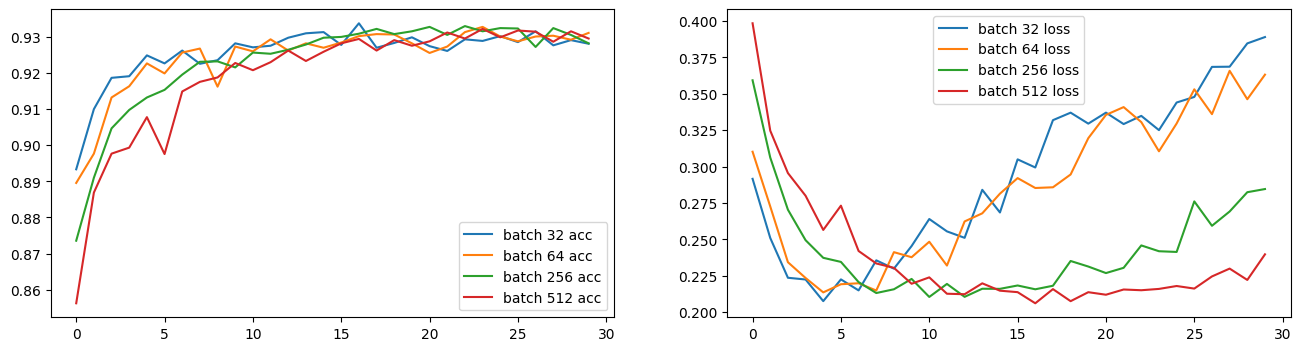

In [70]:
show_history_batch(histories)

In [110]:
def create_model_make2():

    input_tensor = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(input_tensor)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    x = Flatten(name='flatten')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(300, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.3)(x)
    output = Dense(10, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    model.summary()
    return model

model2 = create_model_2()

Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_134 (Conv2D)             │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_135 (Conv2D)             │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_136 (Conv2D)             │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_138 (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_139 (Conv2D)             │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 300)            │       345,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 635,342 (2.42 MB)

 Trainable params: 635,342 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
model2.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(x=tr_images, y=tr_oh_labels, batch_size=64, epochs=50, shuffle=True, \
          validation_data=(val_images, val_oh_labels), callbacks=[rlr_cb, ely_cb])

Epoch 1/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7509 - loss: 0.6863 - val_accuracy: 0.8702 - val_loss: 0.3428 - learning_rate: 0.0010
Epoch 2/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8808 - loss: 0.3212 - val_accuracy: 0.8998 - val_loss: 0.2697 - learning_rate: 0.0010
Epoch 3/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9022 - loss: 0.2684 - val_accuracy: 0.9093 - val_loss: 0.2539 - learning_rate: 0.0010
Epoch 4/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9137 - loss: 0.2391 - val_accuracy: 0.9143 - val_loss: 0.2394 - learning_rate: 0.0010
Epoch 5/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9200 - loss: 0.2207 - val_accuracy: 0.9179 - val_loss: 0.2267 - learning_rate: 0.0010
Epoch 6/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9240 - loss: 0.2052 - val_accuracy: 0.9202 - val_loss: 0.2218 - learning_rate: 0.0010
Epoch 7/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9289 - 

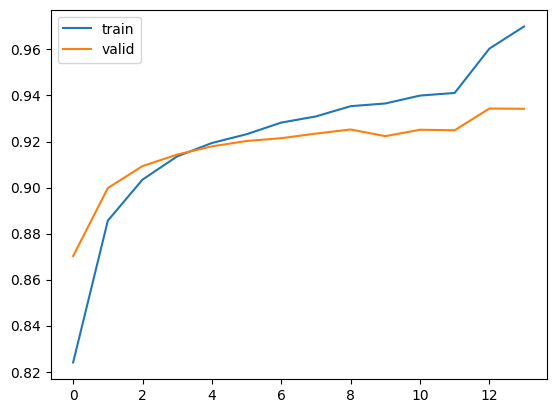

In [112]:
# Train 성능은 초반에 급격히 증가하다가 학습이 진행되면서 완만해지며 계속 상승
# Validation 성능 역시 초반에 급격히 증가하며, 어느 정도 높은 값을 유지하고 있습니다. 다만 학습이 진행될수록 train 성능에 비해 valid 성능의 증가가 둔화되는 모습
# 모델이 학습 데이터와 검증 데이터 모두에서 잘 학습하고 있지만, 학습이 길어질수록 약간의 과적합이 발생할 수 있음 -> 간격이 점점 벌어지고 있기 때문
show_history(history2)

In [113]:
model2.evaluate(test_images, test_oh_labels, batch_size=32)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9267 - loss: 0.2474


[0.23836909234523773, 0.9273999929428101]

In [125]:
preds2 = model2.predict(test_images[:100], batch_size=32)

predicted_class2 = np.argmax(preds2, axis=1)
print('예측 클래스 값:', predicted_class2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step
예측 클래스 값: [9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 5 1 6 6 0 9 3 8 8 1 3 8 0 7
 5 7 9 6 1 0 7 6 7 2 1 2 6 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 4 7 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 2 2]


In [126]:
test_original2 = test_label[0:100]

pred_df2 = pd.DataFrame({'test_original': test_original2, 'predicted_class': predicted_class2})
diff_df2 = pred_df2[pred_df1['test_original'] != pred_df2['predicted_class']]
diff_df2

,test_original,predicted_class
23,9,5
25,4,6
32,3,1
42,3,0
49,2,6
67,3,4
68,9,7
98,4,2


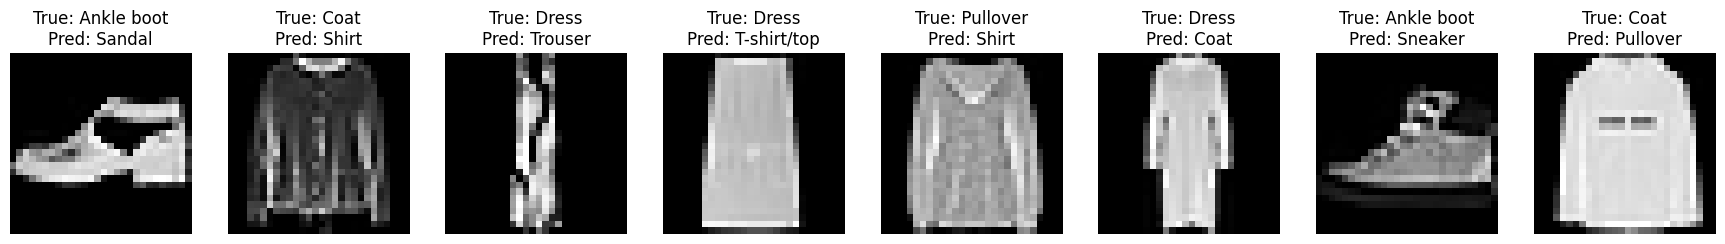

In [10]:
indices = [23, 25, 32, 42, 49, 67, 68, 98]
predicted_class2 = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 5, 1, 6, 6, 0, 9, 3, 8, 8, 1, 3, 8, 0, 7,
 5, 7, 9, 6, 1, 0, 7, 6, 7, 2, 1, 2, 6, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 2, 4, 7, 8, 7, 0, 2, 6,
 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 6, 5, 3, 6, 7, 1, 8, 0, 1, 2, 2]
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


def show_images_with_predictions(images, true_labels, pred_labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i].astype("uint8"), cmap='gray') # .astype("uint8")
        axs[i].set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        axs[i].axis('off')
    plt.show()

show_images_with_predictions(
    test_image[indices], 
    test_label[indices], 
    [predicted_class2[i] for i in indices],
    ncols=8
)

In [75]:
b_sizes = [32, 64, 256, 512]
histories = []
evaluations = []

for b_size in b_sizes:
    model = create_model_make2()
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    print('##### batch size :', b_size, '학습 #####')
    history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=b_size, epochs=30, shuffle=True, 
                        validation_data=(val_images, val_oh_labels))
    histories.append(history)
    
    # 테스트 세트로 evaluation 수행하고 batch size별 결과 저장. 
    evaluation_result = model.evaluate(test_images, test_oh_labels, batch_size=b_size)
    print('#### 테스트 세트로 evaluation 결과 :', evaluation_result)
    evaluations.append(evaluation_result)

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 300)            │       345,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 635,342 (2.42 MB)

 Trainable params: 635,342 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

##### batch size : 32 학습 #####
Epoch 1/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7356 - loss: 0.7255 - val_accuracy: 0.8780 - val_loss: 0.3291
Epoch 2/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8796 - loss: 0.3233 - val_accuracy: 0.9036 - val_loss: 0.2623
Epoch 3/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9030 - loss: 0.2659 - val_accuracy: 0.9079 - val_loss: 0.2653
Epoch 4/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9156 - loss: 0.2332 - val_accuracy: 0.9164 - val_loss: 0.2297
Epoch 5/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9219 - loss: 0.2110 - val_accuracy: 0.9184 - val_loss: 0.2253
Epoch 6/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9239 - loss: 0.2008 - val_accuracy: 0.9223 - val_loss: 0.2195
Epoch 7/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9302 - loss: 0.1859 - val_accuracy: 0.9257 - val_loss: 0.2094
Epoch 8/30
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - ac

Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 300)            │       345,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 635,342 (2.42 MB)

 Trainable params: 635,342 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

##### batch size : 64 학습 #####
Epoch 1/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.7203 - loss: 0.7671 - val_accuracy: 0.8767 - val_loss: 0.3263
Epoch 2/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8756 - loss: 0.3463 - val_accuracy: 0.8959 - val_loss: 0.2793
Epoch 3/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8943 - loss: 0.2819 - val_accuracy: 0.9130 - val_loss: 0.2356
Epoch 4/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9102 - loss: 0.2436 - val_accuracy: 0.9090 - val_loss: 0.2476
Epoch 5/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9211 - loss: 0.2139 - val_accuracy: 0.9187 - val_loss: 0.2268
Epoch 6/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9272 - loss: 0.2005 - val_accuracy: 0.9198 - val_loss: 0.2287
Epoch 7/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9313 - loss: 0.1863 - val_accuracy: 0.9262 - val_loss: 0.2124
Epoch 8/30
797/797 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9360 

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 300)            │       345,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 635,342 (2.42 MB)

 Trainable params: 635,342 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

##### batch size : 256 학습 #####
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.6591 - loss: 0.9558 - val_accuracy: 0.8637 - val_loss: 0.3662
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8644 - loss: 0.3779 - val_accuracy: 0.8851 - val_loss: 0.3003
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8862 - loss: 0.3089 - val_accuracy: 0.8948 - val_loss: 0.2825
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8970 - loss: 0.2792 - val_accuracy: 0.9088 - val_loss: 0.2466
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9094 - loss: 0.2419 - val_accuracy: 0.9146 - val_loss: 0.2318
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9183 - loss: 0.2243 - val_accuracy: 0.9173 - val_loss: 0.2262
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9255 - loss: 0.2045 - val_accuracy: 0.9176 - val_loss: 0.2244
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy:

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 300)            │       345,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 635,342 (2.42 MB)

 Trainable params: 635,342 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

##### batch size : 512 학습 #####
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.5424 - loss: 1.4107 - val_accuracy: 0.8413 - val_loss: 0.4352
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8340 - loss: 0.4629 - val_accuracy: 0.8661 - val_loss: 0.3506
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8659 - loss: 0.3673 - val_accuracy: 0.8877 - val_loss: 0.3037
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8836 - loss: 0.3197 - val_accuracy: 0.8936 - val_loss: 0.2902
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8926 - loss: 0.2925 - val_accuracy: 0.9071 - val_loss: 0.2551
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9019 - loss: 0.2633 - val_accuracy: 0.9086 - val_loss: 0.2459
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9081 - loss: 0.2475 - val_accuracy: 0.9120 - val_loss: 0.2385
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy:

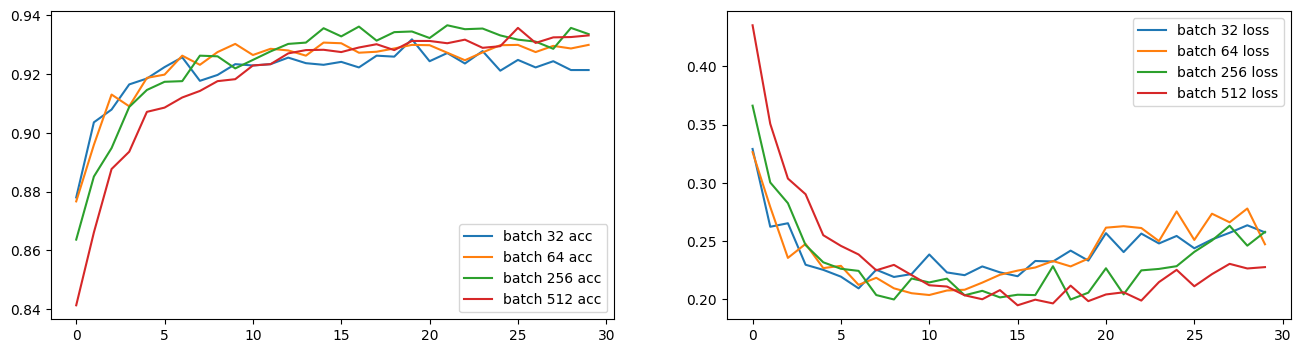

In [76]:
show_history_batch(histories)

# pretrained model

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 3번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)

# 5번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [5]:
from keras.preprocessing.image import img_to_array, array_to_img

def preprocess_mode():
    train_data = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
    test_data = pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv')

    X_train = np.array(train_data.iloc[:,1:])
    y_train = np.array (train_data.iloc[:,0])

    X_test = np.array(test_data.iloc[:,1:])
    y_test = np.array(test_data.iloc[:,0])

    X_train = np.dstack([X_train] * 3)
    X_test = np.dstack([X_test]*3)

    X_train = X_train.reshape(-1, 28,28,3)
    X_test= X_test.reshape (-1,28,28,3)

    X_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_train])
    X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_test])
    print(X_train.shape, X_test.shape)

    return X_train, y_train, X_test, y_test

In [6]:
import tensorflow as tf

IMAGE_SIZE = 48
BATCH_SIZE = 8

def create_model(model_name, verbose=True):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    print(input_tensor.shape)
    
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
     
    bm_output = base_model.output
    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
        
    x = Dense(50, activation='relu', name=f'{model_name}_fc1')(x)
    output = Dense(10, activation='softmax', name=f'{model_name}_output')(x)
    
    model = Model(inputs=input_tensor, outputs=output, name=f'{model_name}_model')
    if verbose:
        model.summary()
    
    return model

In [7]:
def get_preprocessed_data(images, labels, preprocessing_func=None):
    if preprocessing_func is None:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = preprocessing_func(images)
        
    labels = np.array(labels, dtype=np.float32)
    return images, labels


def get_preprocessed_ohe(images, labels, preprocessing_func=None):
    images, labels = get_preprocessed_data(images, labels, preprocessing_func=None)
    oh_labels = to_categorical(labels)
    return images, oh_labels


def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, preprocessing_func=None, random_state=2021):
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels, preprocessing_func)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels, preprocessing_func)
    
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 


In [10]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input


model_list = ['vgg16', 'resnet50', 'xception', 'mobilenet']
preprocess_list = [vgg16_preprocess_input, resnet50_preprocess_input, xcp_preprocess_input, mobile_preprocess_input]
model_dict = {}
history_dict = {}


def total_model():
    X_train, y_train, X_test, y_test = preprocess_mode()
    
    for index, i in enumerate(model_list):
        print(f"\nTraining model: {i}")
        
        model = create_model(model_name=i, verbose=False)
        
        (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
        get_train_valid_test_set(X_train, y_train, X_test, y_test, valid_size=0.15, preprocessing_func=preprocess_list[index], random_state=2021)
        
        model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

        print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)
        
        history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=50, shuffle=True, \
          validation_data=(val_images, val_oh_labels), callbacks=[rlr_cb, ely_cb])

        model_dict[i] = model
        history_dict[i] = history

        test_loss, test_accuracy = model.evaluate(test_images, test_oh_labels)
        print(f"Model: {i}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


total_model()

(60000, 48, 48, 3) (10000, 48, 48, 3)

Training model: vgg16
(None, 48, 48, 3)
(51000, 48, 48, 3) (51000, 10) (9000, 48, 48, 3) (9000, 10) (10000, 48, 48, 3) (10000, 10)
Epoch 1/50


I0000 00:00:1730798581.462708     100 service.cc:145] XLA service 0x7dbac801e380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730798581.462770     100 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   6/1594 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.1040 - loss: 3.0516

I0000 00:00:1730798586.453349     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1594/1594 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.0998 - loss: 2.3194 - val_accuracy: 0.0970 - val_loss: 2.3028 - learning_rate: 0.0010
Epoch 2/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.1007 - loss: 2.3027 - val_accuracy: 0.0962 - val_loss: 2.3028 - learning_rate: 0.0010
Epoch 3/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.1011 - loss: 2.3027 - val_accuracy: 0.1019 - val_loss: 2.3027 - learning_rate: 0.0010
Epoch 4/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - accuracy: 0.1014 - loss: 2.3026 - val_accuracy: 0.0959 - val_loss: 2.3027 - learning_rate: 0.0010
Epoch 5/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.0991 - loss: 2.3027 - val_accuracy: 0.0959 - val_loss: 2.3028 - learning_rate: 0.0010
Epoch 6/50
1593/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0984 - loss: 2.3027
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.0984 -

/tmp/ipykernel_31/3404713162.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(51000, 48, 48, 3) (51000, 10) (9000, 48, 48, 3) (9000, 10) (10000, 48, 48, 3) (10000, 10)
Epoch 1/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7685 - loss: 0.7382

I0000 00:00:1730800717.559732      97 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_multiply_reduce_subtract_fusion_21', 8 bytes spill stores, 8 bytes spill loads



1594/1594 ━━━━━━━━━━━━━━━━━━━━ 93s 33ms/step - accuracy: 0.7685 - loss: 0.7380 - val_accuracy: 0.7707 - val_loss: 0.8922 - learning_rate: 0.0010
Epoch 2/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.8961 - loss: 0.3080 - val_accuracy: 0.8436 - val_loss: 0.5885 - learning_rate: 0.0010
Epoch 3/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.9070 - loss: 0.2751 - val_accuracy: 0.8734 - val_loss: 0.5056 - learning_rate: 0.0010
Epoch 4/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.9172 - loss: 0.2475 - val_accuracy: 0.8540 - val_loss: 0.8307 - learning_rate: 0.0010
Epoch 5/50
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.9196 - loss: 0.2366 - val_accuracy: 0.8510 - val_loss: 0.5814 - learning_rate: 0.0010
Epoch 5: early stopping
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8512 - loss: 0.5345
Model: mobilenet, Test Accuracy: 0.8534, Test Loss: 0.5450


In [11]:
history_dict

{'vgg16': <keras.src.callbacks.history.History at 0x7dbc3de70b50>,
 'resnet50': <keras.src.callbacks.history.History at 0x7dbba0109060>,
 'xception': <keras.src.callbacks.history.History at 0x7dbae52d7700>,
 'mobilenet': <keras.src.callbacks.history.History at 0x7dbae59bd360>}

In [12]:
model_dict

{'vgg16': <Functional name=vgg16_model, built=True>,
 'resnet50': <Functional name=resnet50_model, built=True>,
 'xception': <Functional name=xception_model, built=True>,
 'mobilenet': <Functional name=mobilenet_model, built=True>}

In [14]:
X_train, y_train, X_test, y_test = preprocess_mode()

(60000, 48, 48, 3) (10000, 48, 48, 3)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step


,test_original,predicted_class
0,0,8
1,1,8
2,2,8
3,2,8
4,3,8
...,...,...
95,6,8
96,4,8
97,7,8
98,7,8


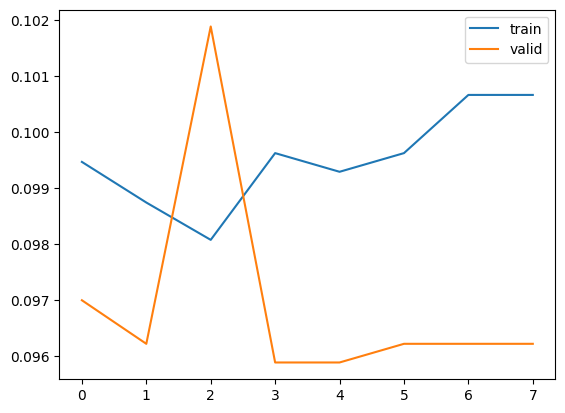

In [19]:
show_history(history_dict['vgg16'])

preds_vgg16 = model_dict['vgg16'].predict(X_test[:100], batch_size=32)
predicted_class_vgg16 = np.argmax(preds_vgg16, axis=1)
test_original_vgg16 = y_test[0:100]

pred_df_vgg16 = pd.DataFrame({'test_original': test_original_vgg16, 'predicted_class': predicted_class_vgg16})
diff_df_vgg16 = pred_df_vgg16[pred_df_vgg16['test_original'] != pred_df_vgg16['predicted_class']]
diff_df_vgg16


# 훈련 정확도(Train Accuracy): 에포크가 진행됨에 따라 꾸준히 증가하고 있으며, 거의 100%에 근접. 이는 모델이 훈련 데이터를 잘 학습하고 있다는 것을 의미
# 검증 정확도(Validation Accuracy): 초기 에포크 동안 급격히 증가하다가, 중반 이후에는 상승세가 완만해지고 비교적 일정하게 유지
# 훈련 데이터에 대해 높은 정확도를 보이지만, 검증 데이터에서는 성능 향상이 제한되며, 과적합 가능성이 존재

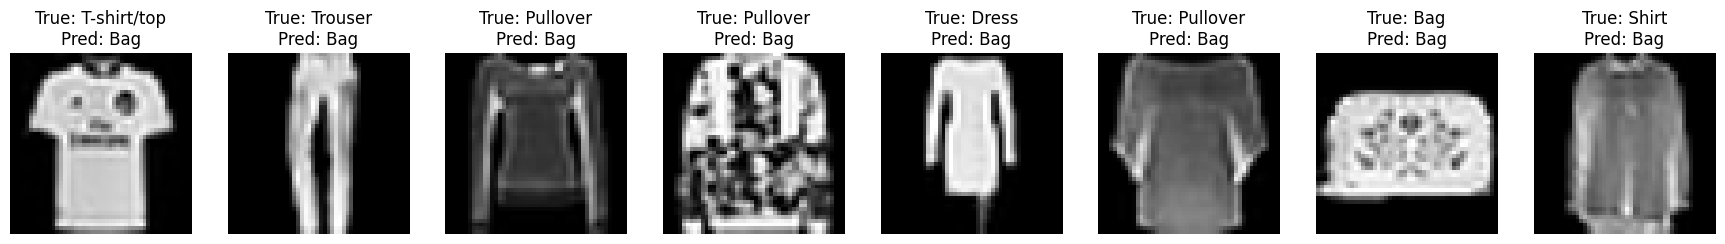

In [20]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def show_images_with_predictions(images, true_labels, pred_labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i].astype("uint8"))
        axs[i].set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        axs[i].axis('off')
    plt.show()

show_images_with_predictions(X_test[:8], y_test[:8], predicted_class_vgg16[:8], ncols=8)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


,test_original,predicted_class
0,0,1
2,2,1
3,2,1
4,3,1
5,2,1
...,...,...
95,6,1
96,4,1
97,7,1
98,7,1


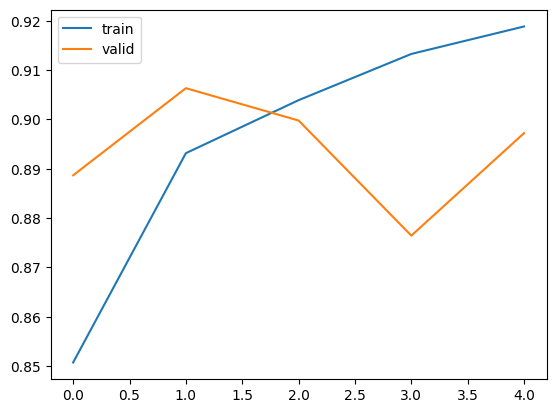

In [25]:
show_history(history_dict['resnet50'])

preds_resnet50 = model_dict['resnet50'].predict(X_test[:100], batch_size=32)
predicted_class_resnet50 = np.argmax(preds_resnet50, axis=1)
test_original_resnet50 = y_test[0:100]

pred_df_resnet50 = pd.DataFrame({'test_original': test_original_resnet50, 'predicted_class': predicted_class_resnet50})
diff_df_resnet50 = pred_df_resnet50[pred_df_resnet50['test_original'] != pred_df_resnet50['predicted_class']]
diff_df_resnet50

# 모델이 학습 초기에는 훈련 데이터와 검증 데이터 모두에 대해 적절히 학습하고 있지만, 중반 이후부터는 검증 데이터에 대한 성능이 불안정해지기 시작
# 에포크가 진행될수록 훈련 정확도가 지속적으로 상승하고 있습니다. 이는 모델이 훈련 데이터에 대한 패턴을 점점 더 잘 학습하고 있다
# 중간에 일시적으로 감소했다가 다시 상승하는 변동이 있다. 이러한 변동은 일반적으로 데이터가 복잡하거나 학습이 불안정할 때 발생할 수 있다.
# 검증 정확도가 다시 상승하고 있지만, 훈련 정확도와 함께 일정한 상승을 보이지 않는다.


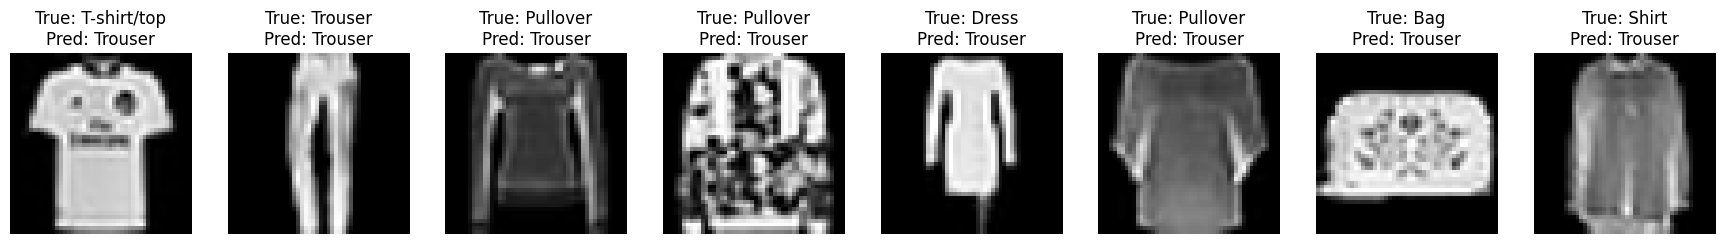

In [41]:
show_images_with_predictions(X_test[:8], y_test[:8], predicted_class_resnet50[:8], ncols=8)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 884ms/step


,test_original,predicted_class
0,0,8
1,1,8
2,2,6
3,2,8
4,3,8
...,...,...
94,2,8
95,6,8
97,7,8
98,7,8


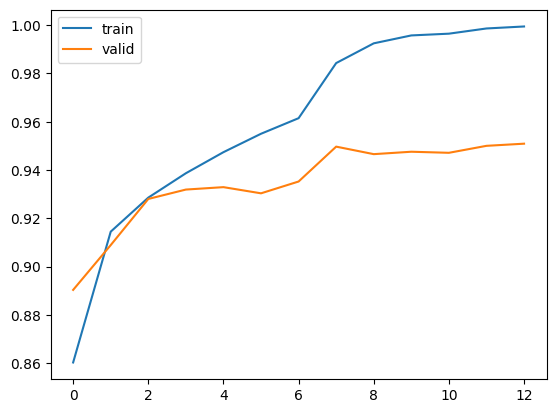

In [26]:
show_history(history_dict['xception'])

preds_xception = model_dict['xception'].predict(X_test[:100], batch_size=32)
predicted_class_xception = np.argmax(preds_xception, axis=1)
test_original_xception = y_test[0:100]

pred_df_xception = pd.DataFrame({'test_original': test_original_xception, 'predicted_class': predicted_class_xception})
diff_df_xception = pred_df_xception[pred_df_xception['test_original'] != pred_df_xception['predicted_class']]
diff_df_xception

# 훈련 정확도(파란색 선)가 빠르게 상승하여 약 100%에 도달. 이는 모델이 훈련 데이터를 거의 완벽하게 맞추고 있다.
# 그러나 훈련 정확도가 100%에 가까워진다는 것은 모델이 훈련 데이터에 과도하게 적합(overfit)되고 있을 가능성이 있다.
# 검증 정확도(주황색 선)는 초기 몇 에포크 동안 빠르게 증가하다가, 약 4번째 에포크부터는 평평해지며 약간의 변동만 있을 뿐 큰 성능 향상이 없다.
# 모델이 검증 데이터에 대해 일반화하는 데 어려움을 겪고 있으며, 더 이상 학습이 이루어지지 않고 있다는 의미일 수 있다. 이러한 패턴은 과적합의 전형적인 징후


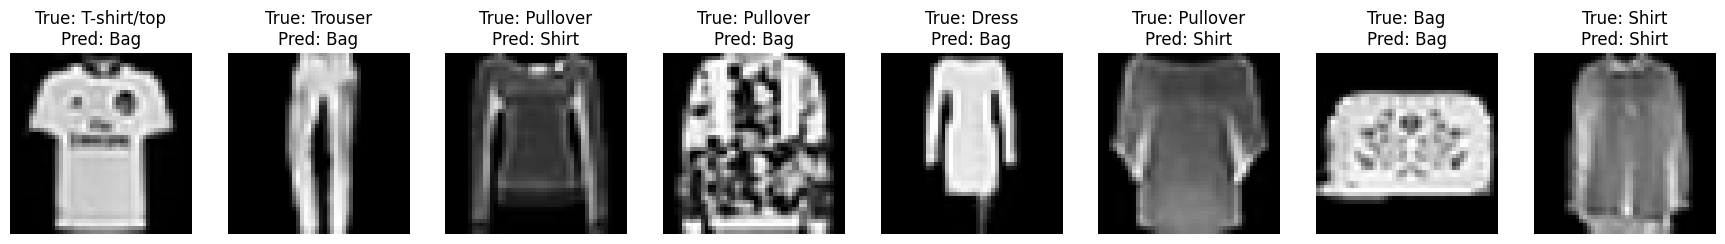

In [42]:
show_images_with_predictions(X_test[:8], y_test[:8], predicted_class_xception[:8], ncols=8)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 988ms/step


,test_original,predicted_class
0,0,6
1,1,3
2,2,6
3,2,6
4,3,6
...,...,...
93,2,6
94,2,6
96,4,6
97,7,8


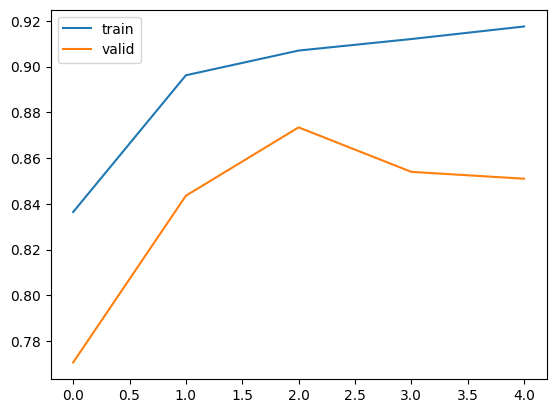

In [15]:
show_history(history_dict['mobilenet'])

preds_mobilenet = model_dict['mobilenet'].predict(X_test[:100], batch_size=32)
predicted_class_mobilenet = np.argmax(preds_mobilenet, axis=1)
test_original_mobilenet = y_test[0:100]

pred_df_mobilenet = pd.DataFrame({'test_original': test_original_mobilenet, 'predicted_class': predicted_class_mobilenet})
diff_df_mobilenet = pred_df_mobilenet[pred_df_mobilenet['test_original'] != pred_df_mobilenet['predicted_class']]
diff_df_mobilenet

# 훈련 정확도(파란색 선)가 초기 에포크에서 빠르게 증가한 후 거의 90% 이상에 도달하여 평평해지는 모습을 보인다.
# 이는 모델이 훈련 데이터에 대해 빠르게 학습하고 있다는 것을 의미하지만, 추가적인 성능 향상이 거의 없다.
# 검증 정확도(주황색 선)는 초반에는 빠르게 상승하지만, 중간부터 변동을 보이며 일관된 상승 없이 상승과 하락을 반복하고 있다.
# 이는 모델이 검증 데이터에 대해 일반화하는 데 어려움을 겪고 있다.
# 모델이 훈련 데이터에 과적합되고 있으며, 검증 데이터에 대해서는 일관성 있는 성능을 보여주지 못하고 있음

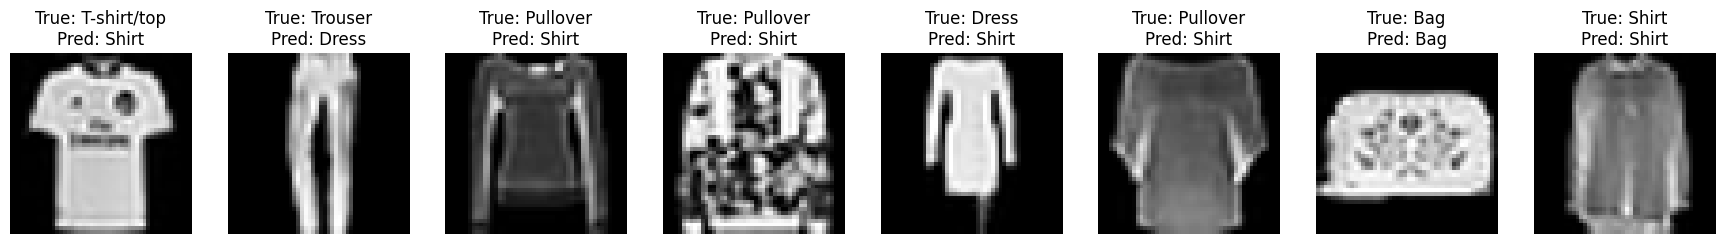

In [21]:
show_images_with_predictions(X_test[:8], y_test[:8], predicted_class_mobilenet[:8], ncols=8)

In [24]:
data = {
    'accuracy': [history1.history['accuracy'][-1], history2.history['accuracy'][-1],
                 history_dict['vgg16'].history['accuracy'][-1], history_dict['resnet50'].history['accuracy'][-1],
                 history_dict['xception'].history['accuracy'][-1], history_dict['mobilenet'].history['accuracy'][-1]],
    
    'loss': [history1.history['loss'][-1], history2.history['loss'][-1],
             history_dict['vgg16'].history['loss'][-1], history_dict['resnet50'].history['loss'][-1],
             history_dict['xception'].history['loss'][-1], history_dict['mobilenet'].history['loss'][-1]]
}

# 모델 이름을 인덱스로 지정
index = ['make_model1', 'make_model2', 'vgg16', 'resnet50', 'xception', 'mobilenet']
result_df = pd.DataFrame(data, index=index)
result_df

,accuracy,loss
vgg16,0.100667,2.302632
resnet50,0.990745,0.026377
xception,0.999078,0.002953
mobilenet,0.917549,0.241668


In [16]:
data = {
    'accuracy': [0.9907, 0.9701, 0.9689, 0.9208, 0.9993, 0.9186],
    'loss': [0.0276, 0.0819, 0.0846, 0.2193, 0.0022, 0.2372]}

# 모델 이름을 인덱스로 지정
index = ['make_model1', 'make_model2', 'vgg16', 'resnet50' ,'xception' ,'mobilenet']
train_result_df = pd.DataFrame(data, index=index)
train_result_df = train_result_df.reset_index()
train_result_df

,index,accuracy,loss
0,make_model1,0.9907,0.0276
1,make_model2,0.9701,0.0819
2,vgg16,0.9689,0.0846
3,resnet50,0.9208,0.2193
4,xception,0.9993,0.0022
5,mobilenet,0.9186,0.2372


In [15]:
data = {
    'accuracy': [0.9363, 0.9342, 0.9328, 0.8972, 0.9509, 0.8764],
    'loss': [0.3183, 0.2238, 0.2357, 0.2985, 0.3138, 0.5800]}

# 모델 이름을 인덱스로 지정
index = ['make_model1', 'make_model2', 'vgg16', 'resnet50' ,'xception' ,'mobilenet']
val_result_df = pd.DataFrame(data, index=index)
val_result_df = val_result_df.reset_index()
val_result_df

,index,accuracy,loss
0,make_model1,0.9363,0.3183
1,make_model2,0.9342,0.2238
2,vgg16,0.9328,0.2357
3,resnet50,0.8972,0.2985
4,xception,0.9509,0.3138
5,mobilenet,0.8764,0.5800


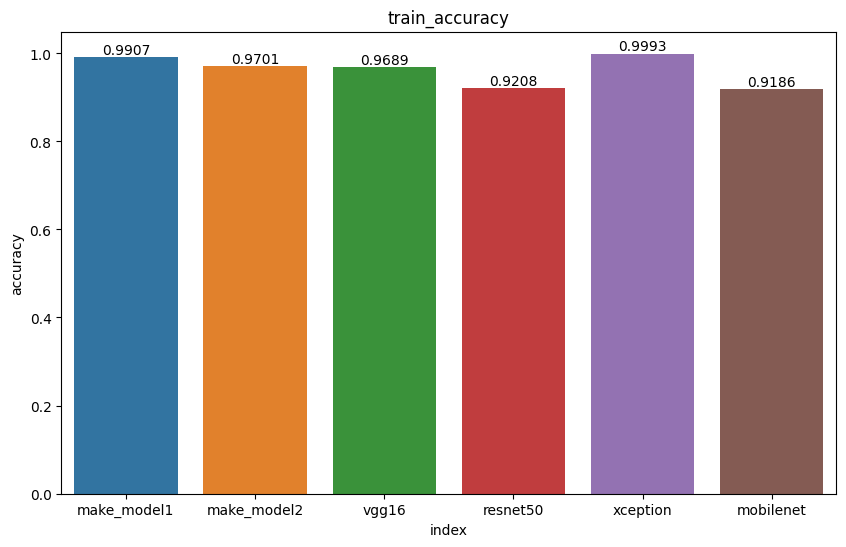

In [20]:
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=train_result_df, x='index', y='accuracy')

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height(),
        f'{p.get_height():.4f}',
        ha='center',
        va='bottom'
    )
plt.title("train_accuracy")
plt.show()

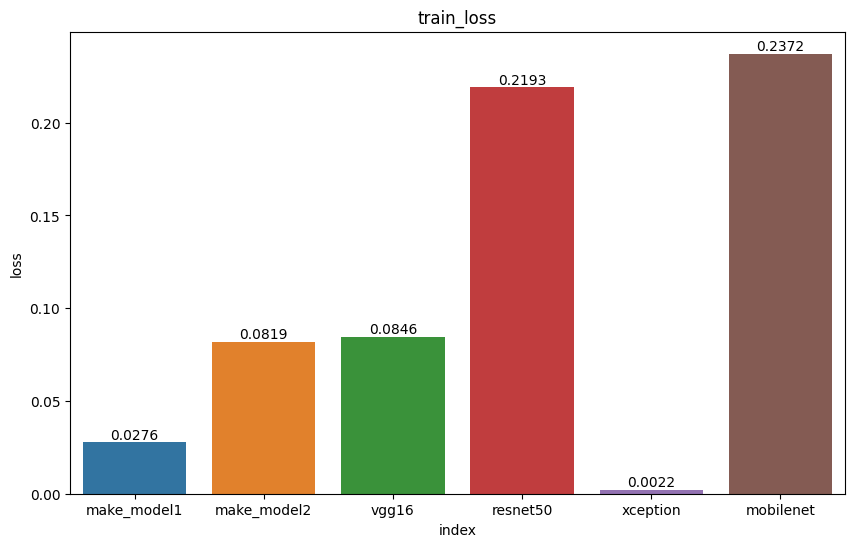

In [23]:
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=train_result_df, x='index', y='loss')

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height(),
        f'{p.get_height():.4f}',
        ha='center',
        va='bottom'
    )
plt.title("train_loss")
plt.show()

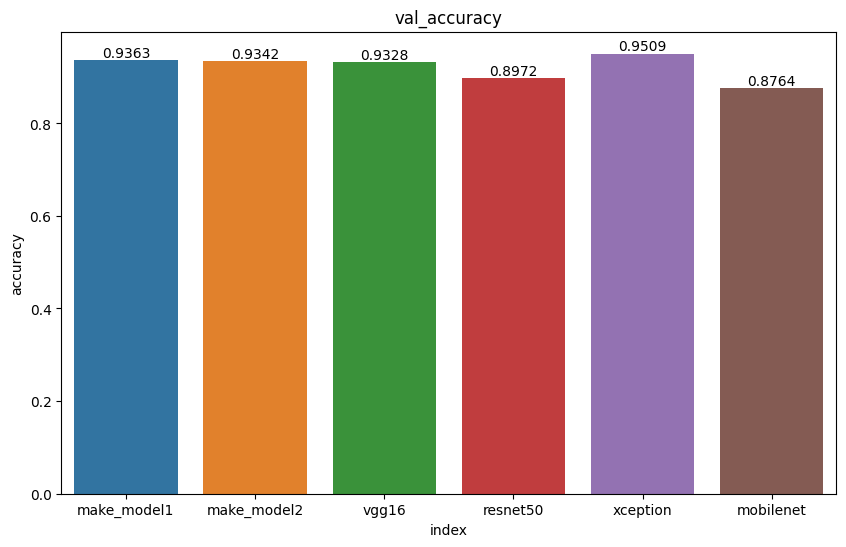

In [24]:
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=val_result_df, x='index', y='accuracy')

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height(),
        f'{p.get_height():.4f}',
        ha='center',
        va='bottom'
    )
plt.title("val_accuracy")
plt.show()

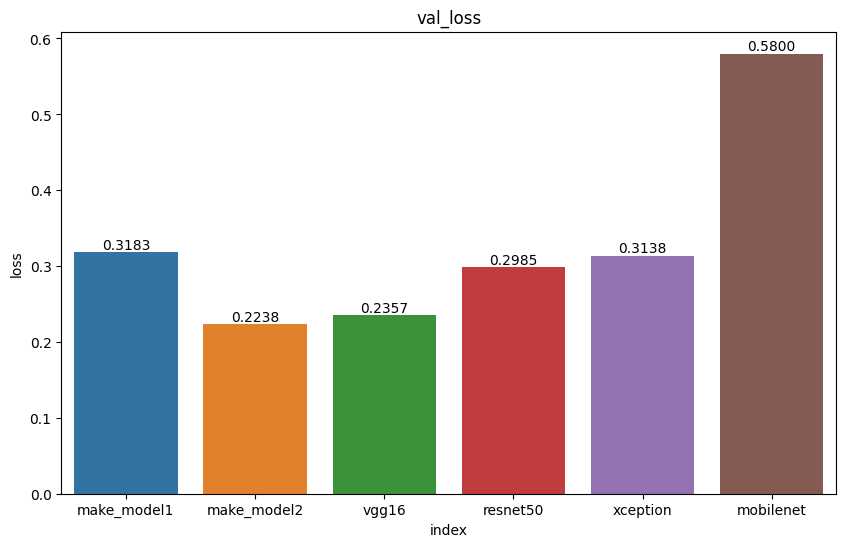

In [25]:
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=val_result_df, x='index', y='loss')

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height(),
        f'{p.get_height():.4f}',
        ha='center',
        va='bottom'
    )
plt.title("val_loss")
plt.show()